In [1]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional: Venn diagram
try:
    from matplotlib_venn import venn2
except ImportError:
    print("matplotlib-venn not installed. Install with: pip install matplotlib-venn")

# Base paths (relative to notebooks/)
PROJECT_ROOT = Path("..").resolve()
DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

FEATURES_PATH = DATA_PROCESSED / "combined_features.csv"
MPD_DIR = DATA_RAW / "mpd"

print("Features CSV:", FEATURES_PATH)
print("MPD dir:", MPD_DIR)


Features CSV: C:\Users\Kiera\Music_Recommender\data\processed\combined_features.csv
MPD dir: C:\Users\Kiera\Music_Recommender\data\raw\mpd


In [2]:
# Load combined features
features_df = pd.read_csv(FEATURES_PATH)

print("combined_features.csv shape:", features_df.shape)
print("Columns:", list(features_df.columns))

features_df.head()


combined_features.csv shape: (4589288, 17)
Columns: ['track_id', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'year', 'explicit', 'time_signature', 'popularity']


,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year,explicit,time_signature,popularity
0,0000QuApNltQzqS5ROXcQ7,0.629,0.199,4,-15.258,1,0.0610,0.9250,0.000000,0.1100,0.587,66.469,141813.0,2012.0,NaN,4.0,NaN
1,0000j9zugybaOxAeENtFRU,0.680,0.378,5,-7.379,1,0.0685,0.8850,0.000013,0.1200,0.963,116.877,112107.0,NaN,NaN,4.0,NaN
2,0000korRHja9p9XaR5UA5m,0.708,0.714,6,-7.579,1,0.0362,0.3970,0.000047,0.3540,0.756,120.538,235666.0,1995.0,NaN,4.0,NaN
3,0000uJA4xCdxThagdLkkLR,0.458,0.591,5,-5.621,1,0.0326,0.5680,0.000015,0.2860,0.654,184.913,161187.0,NaN,NaN,3.0,NaN
4,00018DRtkxXS7SmAG4ciN6,0.456,0.324,8,-11.521,1,0.0342,0.0242,0.596000,0.0868,0.522,184.970,238827.0,NaN,NaN,3.0,NaN


In [3]:
# We assume track_id is the column holding Spotify IDs
if "track_id" not in features_df.columns:
    raise KeyError("Expected 'track_id' column in combined_features.csv")

feature_track_ids = set(features_df["track_id"].dropna().astype(str))

print(f"Unique track_ids in combined_features: {len(feature_track_ids):,}")


Unique track_ids in combined_features: 4,589,288


In [4]:
def extract_track_id_from_uri(uri: str) -> str | None:
    """
    Convert 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI' → '0UaMYEvWZi0ZqiDOoHU3YI'.
    """
    if not isinstance(uri, str):
        return None
    parts = uri.split(":")
    return parts[-1] if len(parts) >= 3 else None

# Find all MPD slice JSON files (recursively, in case they’re under mpd/data/)
mpd_files = sorted(MPD_DIR.rglob("mpd.slice.*.json"))
print(f"Found {len(mpd_files)} MPD slice files")

mpd_track_ids = set()
total_playlists = 0
total_track_entries = 0

for path in mpd_files:
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    playlists = data.get("playlists", [])
    total_playlists += len(playlists)

    for pl in playlists:
        tracks = pl.get("tracks", [])
        total_track_entries += len(tracks)
        for t in tracks:
            uri = t.get("track_uri")
            tid = extract_track_id_from_uri(uri)
            if tid:
                mpd_track_ids.add(tid)

print("\n=== MPD Stats ===")
print(f"Total playlists in these slices:          {total_playlists:,}")
print(f"Total track entries (with duplicates):    {total_track_entries:,}")
print(f"Unique track IDs in MPD (from slices):    {len(mpd_track_ids):,}")


Found 100 MPD slice files

=== MPD Stats ===
Total playlists in these slices:          100,000
Total track entries (with duplicates):    6,685,101
Unique track IDs in MPD (from slices):    679,889


In [5]:
# Intersection
intersection_ids = feature_track_ids & mpd_track_ids

n_feat = len(feature_track_ids)
n_mpd = len(mpd_track_ids)
n_intersection = len(intersection_ids)

print("=== Overlap Summary ===")
print(f"Unique track IDs in combined_features:      {n_feat:,}")
print(f"Unique track IDs in MPD:                    {n_mpd:,}")
print(f"Overlap (tracks present in BOTH):           {n_intersection:,}")
print(f"  - % of MPD covered by features:           {n_intersection / n_mpd * 100:.2f}%")
print(f"  - % of features that appear in MPD:       {n_intersection / n_feat * 100:.2f}%")

# Build a small summary table
summary_rows = [
    {
        "set": "combined_features only",
        "count": n_feat - n_intersection,
        "pct_of_features": (n_feat - n_intersection) / n_feat * 100,
        "pct_of_mpd": 0.0,
    },
    {
        "set": "MPD only",
        "count": n_mpd - n_intersection,
        "pct_of_features": 0.0,
        "pct_of_mpd": (n_mpd - n_intersection) / n_mpd * 100,
    },
    {
        "set": "Intersection (both)",
        "count": n_intersection,
        "pct_of_features": n_intersection / n_feat * 100,
        "pct_of_mpd": n_intersection / n_mpd * 100,
    },
]

overlap_df = pd.DataFrame(summary_rows)
print("\n=== Overlap Table ===")
display(overlap_df)


=== Overlap Summary ===
Unique track IDs in combined_features:      4,589,288
Unique track IDs in MPD:                    679,889
Overlap (tracks present in BOTH):           514,672
  - % of MPD covered by features:           75.70%
  - % of features that appear in MPD:       11.21%

=== Overlap Table ===


,set,count,pct_of_features,pct_of_mpd
0,combined_features only,4074616,88.785363,0.000000
1,MPD only,165217,0.000000,24.300584
2,Intersection (both),514672,11.214637,75.699416


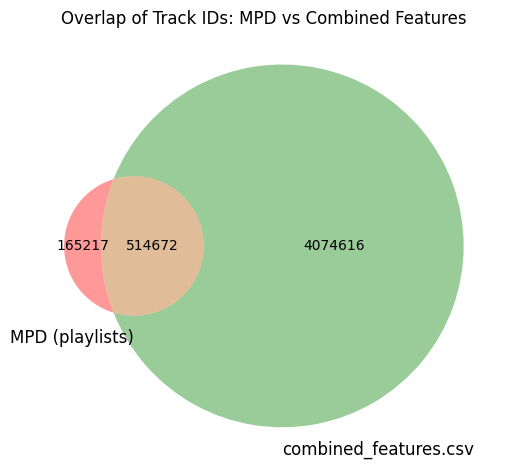

In [6]:
if "venn2" not in globals():
    try:
        from matplotlib_venn import venn2
    except Exception as e:
        print("Could not import matplotlib_venn. Install it with:")
        print("  pip install matplotlib-venn")
        raise e

plt.figure(figsize=(6, 6))
venn2(
    subsets=(
        n_mpd - n_intersection,      # MPD only
        n_feat - n_intersection,     # Features only
        n_intersection               # Both
    ),
    set_labels=("MPD (playlists)", "combined_features.csv")
)
plt.title("Overlap of Track IDs: MPD vs Combined Features")
plt.show()


In [7]:
# Take a small sample of overlapping IDs
sample_ids = list(intersection_ids)
if len(sample_ids) > 20:
    sample_ids = np.random.choice(sample_ids, size=20, replace=False)

sample_ids = list(sample_ids)

# Look these up in features_df (if you later add names/metadata there)
overlap_features_sample = features_df[features_df["track_id"].isin(sample_ids)]

print("Sample of overlapping tracks from combined_features:")
display(overlap_features_sample.head(20))


Sample of overlapping tracks from combined_features:


,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year,explicit,time_signature,popularity
96439,09UiGAB2QAAlneHdI6GuI6,0.265,0.945,7,-6.893,1,0.2070,0.000011,0.244000,0.2960,0.224,121.283,286933.0,NaN,NaN,4.0,NaN
555045,0uMQfn0xFPYlerLT9pkJxX,0.360,0.986,1,-2.855,1,0.2330,0.000116,0.000927,0.0845,0.219,199.901,228627.0,2011.0,NaN,4.0,18.0
1071519,1lyrB1YrbZCCN2RxUcxPRJ,0.363,0.978,11,-4.476,0,0.1860,0.000046,0.940000,0.2560,0.239,123.023,155213.0,NaN,NaN,4.0,NaN
1267715,26WJMsesrV9FuKNgZ25zW7,0.546,0.207,7,-15.335,1,0.0340,0.150000,0.000000,0.1270,0.371,121.759,175000.0,1985.0,0,3.0,44.0
1485351,2TLUVGD44qTMPjiCQTGWgK,0.450,0.924,9,-6.725,1,0.0639,0.000323,0.011300,0.1210,0.409,132.658,232653.0,1998.0,False,4.0,NaN
1510667,2Vzp3Z9epCdIfYbMNqjgHD,0.791,0.672,5,-6.072,0,0.1990,0.001660,0.843000,0.2670,0.299,125.981,219048.0,NaN,NaN,4.0,NaN
1719850,2rvHIXjN4TCFuFLZk3qAxn,0.738,0.870,1,-5.343,0,0.0844,0.012400,0.000000,0.1400,0.845,89.988,205733.0,2014.0,NaN,4.0,37.0
2185779,3fBycIyaH4mugmXClwGgr9,0.781,0.821,0,-5.683,1,0.1020,0.116000,0.000000,0.1790,0.924,100.803,259947.0,NaN,NaN,4.0,NaN
2203185,3h1jzvb6xgXEssYybVnNJV,0.611,0.548,0,-5.771,1,0.0411,0.381000,0.000000,0.1390,0.679,117.686,213787.0,2005.0,False,4.0,NaN
2227725,3jeI2F4R1JzfYlG8VV7fqK,0.591,0.708,6,-8.461,0,0.0707,0.426000,0.000467,0.2920,0.534,74.985,257086.0,2010.0,NaN,4.0,15.0
